In [44]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [45]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [46]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [47]:
def build_dataset(words_list, block_size=3):
    X, Y = [], []

    for w in words_list:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

def split_data(X, Y, ratios=(0.8, 0.1, 0.1)):
    n1 = int(ratios[0] * len(words))
    n2 = int((ratios[0] + ratios[1]) * len(words))

    Xtr, Ytr = X[:n1], Y[:n1]
    Xdev, Ydev = X[n1:n2], Y[n1:n2]
    Xte, Yte = X[n2:], Y[n2:]

    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [48]:
# Build Dataset
X, Y = build_dataset(words)

# Split Data
Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_data(X, Y)


In [71]:
class MyNeuralNetwork:
    def __init__(self, block_size=3, embedding_size=2, hidden_size=100):
        self.C = torch.randn(27, embedding_size, requires_grad=True)  # Set requires_grad=True
        self.W1 = torch.randn(block_size * embedding_size, hidden_size, requires_grad=True)  # Set requires_grad=True
        self.b1 = torch.randn(hidden_size, requires_grad=True)  # Set requires_grad=True
        self.W2 = torch.randn(hidden_size, 27, requires_grad=True)  # Set requires_grad=True
        self.b2 = torch.randn(27, requires_grad=True)  # Set requires_grad=True
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

    def forward(self, X):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, emb.size(-1) * emb.size(-2)) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def validate(self, X, Y):
        with torch.no_grad():
            logits = self.forward(X)
            loss = F.cross_entropy(logits, Y)
        return loss.item()

    def train(self, X, Y, batch_size=32, learning_rate=0.01, num_epochs=10000):
        train_loss = []
        val_loss = []

        for epoch in range(num_epochs):
            ix = torch.randint(0, X.shape[0], (batch_size, ))
            logits = self.forward(X[ix])
            loss = F.cross_entropy(logits, Y[ix])

            for p in self.parameters:
                p.grad = None

            loss.backward()

            if isinstance(learning_rate, float):
                for p in self.parameters:
                    p.data += -learning_rate * p.grad
                if epoch % 100 == 0:
                    val_loss.append(self.validate(Xdev, Ydev))
                    train_loss.append(loss.item())
            elif isinstance(learning_rate, list):
                lrs = []
                for p in self.parameters:
                    p.data += -learning_rate[epoch] * p.grad
                lrs.append(learning_rate[epoch])    
                val_loss.append(self.validate(Xdev, Ydev))
                train_loss.append(loss.item())
                


                # print(f'Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss[-1]}')

        return train_loss, val_loss

In [78]:
def visualize_loss(train_loss, val_loss, learning_rates=None):
    if learning_rates == None:
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epoch (100x)')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    else:
        plt.plot(learning_rates, train_loss, label='Training Loss')
        plt.plot(learning_rates, val_loss, label='Validation Loss')
        # plt.xticks(learning_rates)
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

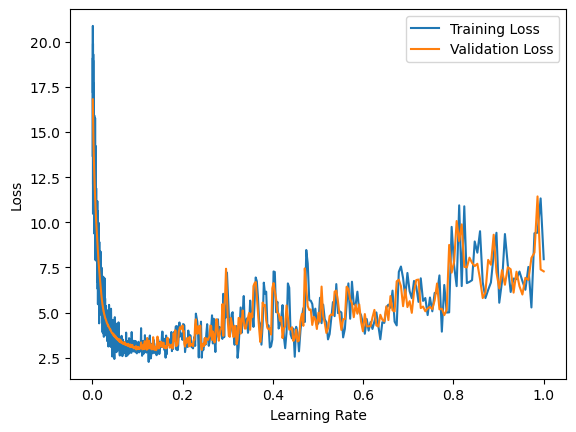

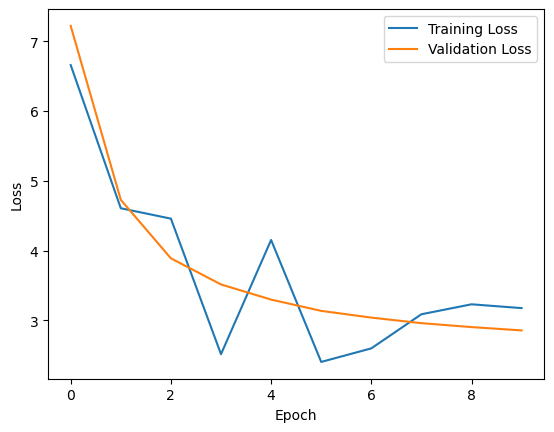

In [79]:
# Example usage with single learning rate
net = MyNeuralNetwork()
lrs = list(10**np.linspace(-3, 0, 1000))

train_loss, val_loss = net.train(Xtr, Ytr, learning_rate=lrs, num_epochs=1000)
visualize_loss(train_loss, val_loss, learning_rates=lrs)


train_loss, val_loss = net.train(Xtr, Ytr, learning_rate=0.01, num_epochs=1000)
visualize_loss(train_loss, val_loss)

In [80]:
test_loss = net.validate(Xte, Yte)
test_loss

3.096374988555908

In [ ]:
net = MyNeuralNetwork()
lrs = list(10**np.linspace(-3, 0, 1000))

train_loss, val_loss = net.train(Xtr, Ytr, learning_rate=lrs, num_epochs=1000)
visualize_loss(train_loss, val_loss, learning_rates=lrs)


train_loss, val_loss = net.train(Xtr, Ytr, learning_rate=0.01, num_epochs=1000)
visualize_loss(train_loss, val_loss)